In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4,5,6,7
no_gpu = 4
%matplotlib inline
import numpy as np
import scipy
import scipy.stats
import operator
import pandas as pd
from __future__ import print_function
import os
import cPickle as pickle
import math
from time import time
from datetime import datetime
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(1337)  # for reproducibility

nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 500  # number of epoch at training (cont) stage
batch_size = 15  # batch size

lr = 0.001  # learning rate
len_closeness = 15  # length of closeness dependent sequence
nb_residual_unit = 4   # number of residual units
year_test = 2006
nb_flow = 1  # there are two types of flows: new-flow and end-flow
path_result = 'RET'
path_model = 'MODEL'

if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)
data_path = '/notebooks/workspace/flood/www.ncei.noaa.gov/data/precipitation-persiann/'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4,5,6,7


Using TensorFlow backend.


### Load Data

In [2]:
from persiann import sample_construction
if os.path.isfile('X.npy') is False: 
    print ('start creating samples.')
    sc = sample_construction(data_path=data_path,end_year=2016)
    sc.create_samples(target_river = 'G')

In [3]:
E = np.load('E.npy') #external input
X = np.load('X.npy')
Y = pd.read_pickle('Y_df.pkl')
map_height, map_width = X.shape[2], X.shape[3]
print('E: ',E.shape,'X: ',X.shape,'Y: ',Y.shape)

E:  (4148, 5) X:  (4148, 15, 92, 188) Y:  (4148, 1)


(4148, 15, 92, 188)


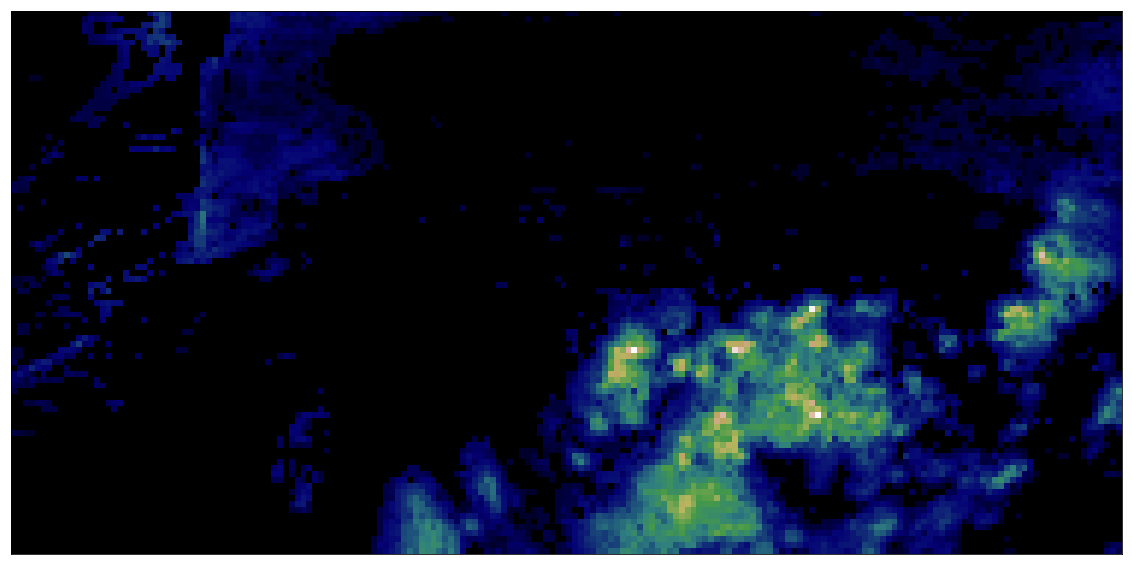

In [7]:
plt.figure(figsize=(20,10))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
print (X.shape)
plt.imshow(X[0,14], cmap='gist_earth', interpolation='nearest')
plt.show()

In [ ]:
print(np.max(X[:10]))

In [ ]:
print (X[X>0].shape)

In [ ]:
print (X[X==0].shape)
print(X.shape)

In [3]:
def distribution_plot(y,fit):
    overall_min = np.min(y)
    overall_max = np.max(y)
    #print (overall_max,overall_min)
    bins = np.linspace(overall_min, overall_max, 50)
    #print(bins)   
    fig = plt.figure()
    fig.set_size_inches(15, 10)
    print (y.shape)  
    n, bins, patches = plt.hist(y, bins, alpha=0.5, density=fit, facecolor='g')#log=True
    #print (n)
    #print (bins)
    #print(patches)
#(x, 50, density=True, facecolor='g', alpha=0.75)
    #print(bins)
    #dist_names = ['rayleigh', 'norm', 'pareto']
    #dist_names = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
    #dist_names = ['invgauss', 'foldcauchy', 'lomax', 'halfcauchy', 'pareto', 'alpha', 'genexpon', 'expon', 'gompertz', 'halflogistic', 'genhalflogistic', 'halfnorm', 'foldnorm', 'gilbrat', 'uniform', 'ksone', 'truncnorm', 'wald', 'bradford', 'triang', 'truncexpon', 'semicircular', 'kstwobign', 'rice', 'rayleigh', 'frechet_l', 'wrapcauchy', 'gumbel_r', 'genlogistic', 'weibull_max', 'maxwell', 'anglit', 'norm', 'loggamma', 'logistic', 'hypsecant', 'cauchy', 'gumbel_l', 'powernorm', 'laplace', 'reciprocal', 'cosine']
    dist_names = ['pareto','norm','alpha','logistic', 'hypsecant', 'cauchy', 'gumbel_l', 'powernorm', 'laplace', 'reciprocal']#'reciprocal'
    #dist_names = ['gumbel_l','logistic','norm','alpha','cauchy', 'laplace']# 
    #dist_names = ['pareto','norm','genpareto', 'halfnorm', 'expon' ]
    #dist_names = ['lognorm']
    #dist_names = ['arcsine', 'truncexpon', 'semicircular', 'anglit', 'triang', 'genhalflogistic', 'lomax', 'expon', 'betaprime', 'exponpow', 'loglaplace', 'fisk', 'exponweib', 'invweibull', 'gumbel_r', 'genlogistic',  'genpareto',  'foldnorm', 'kstwobign','halfcauchy',  'rayleigh',  'rice', 'maxwell',  'cosine', 'mielke',  'genexpon',  'dgamma']
    #dist_names = ['truncexpon', 'semicircular', 'anglit', 'triang', 'genhalflogistic', 'loglaplace', 'betaprime','fisk', 'exponweib', 'invweibull', 'gumbel_r', 'genlogistic',  'genpareto',  'foldnorm', 'kstwobign','halfcauchy',  'rayleigh',  'rice', 'maxwell',  'cosine', 'mielke',  'genexpon',  'dgamma']
    
    dic = {}
    print('here111111')
    if fit:
        for dist_name in dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            print('here2222222')
            pdf_fitted = dist.pdf(bins, *param[:-2], loc=param[-2], scale=param[-1])       
            NLL = -np.sum(np.log(pdf_fitted))
            print ("Dist: {0}, NLL: {1}".format(dist_name, NLL))
            dic[dist_name]=NLL
            plt.plot(bins, pdf_fitted, label=dist_name+', NLL: '+str(NLL))
        sorted_dic = sorted(dic.items(), key=operator.itemgetter(1))
        print (sorted_dic)
    #plt.xlim(xmin,xmax)
    #plt.ylim(ymin,ymax)
    plt.legend(loc='upper right')
    plt.xlabel('Daily Stream Flow')
    plt.ylabel('Number of Days')
    plt.show()
#plt.xticks(bins, ["2^%s" % i for i in bins])

In [ ]:
data = X[:,0,10,10]#np.array(np.log(1+Y))#np.log(0.5+y)
data = np.array(np.log(0.5+data))
sorted_dic = distribution_plot(data,False)
print ('min: '+str(np.min(data)))
print ('max: '+str(np.max(data)))
print ('mean: '+str(np.mean(data)))
print ('median: '+str(np.median(data)))
print ('standard deviation: '+str(np.std(data)))
print ('75% percentile: '+str(np.percentile(data,75)))
ratio = (np.max(data)-np.percentile(data,75))/(np.max(data) - np.min(data))
print ('>75% percentile ratio= '+str(ratio))

In [ ]:
#ymax,ymin = 450,0
#xmax,xmin = 2.2,0
#xmax,xmin = 2200,0
#distribution_plot(y,omax,omin)
data = Y#np.array(np.log(1+Y))#np.log(0.5+y)
sorted_dic = distribution_plot(data,False)
print ('min: '+str(np.min(data)))
print ('max: '+str(np.max(data)))
print ('mean: '+str(np.mean(data)))
print ('median: '+str(np.median(data)))
print ('standard deviation: '+str(np.std(data)))
print ('75% percentile: '+str(np.percentile(data,75)))
ratio = (np.max(data)-np.percentile(data,75))/(np.max(data) - np.min(data))
print ('>75% percentile ratio= '+str(ratio))
#data =np.log(1+y)/np.log(1.6) 
#distribution_plot(data,omax,omin)
#data =np.log(1+y)/np.log(1.5) 
#distribution_plot(data,omax,omin)
#data =np.log(1+y)/np.log(1.1) 
#distribution_plot(data,omax,omin)

(4148, 1)


In [ ]:
Y = np.log(1+Y)
train_idx  = Y.index.year < year_test
test_idx  = Y.index.year >= year_test
#X=np.reshape(X,(:, np.newaxis,...))
#X = X[:, np.newaxis,...]
E_train, X_train, Y_train, E_test, X_test, Y_test = E[train_idx], X[train_idx],Y.iloc[train_idx],E[test_idx],X[test_idx],Y.iloc[test_idx]
print ('E_train shape', E_train.shape,'X_train shape', X_train.shape, 'Y_train shape', Y_train.shape,'E_test shape', E_test.shape,'X_test shape', X_test.shape, 'Y_test shape', Y_test.shape)

In [ ]:
print (Y[:50])

### Build Network

In [ ]:
from keras import backend as K
#Root Mean Squared Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
#Root Mean Squared Logarithmic Error
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(tf.log1p(y_pred) - tf.log1p(y_true))))

In [ ]:
import residualnet as rn
from keras.utils import multi_gpu_model

def build_model(external_dim):
    c_conf = (len_closeness, nb_flow, map_height,
              map_width) if len_closeness > 0 else None

    model = rn.stresnet(c_conf=c_conf, p_conf=None, t_conf=None,
                     external_dim=external_dim, nb_residual_unit=nb_residual_unit, is_3D=False, batchNormalization=False) 
    
    parallel_model = multi_gpu_model(model, gpus=no_gpu)
    
    adam = Adam(lr=lr)
    parallel_model.compile(loss='mse', optimizer=adam, metrics=[rmse])
    parallel_model.summary()
    # from keras.utils.visualize_util import plot
    # plot(model, to_file='model.png', show_shapes=True)
    return parallel_model

In [ ]:
external_dim = E_train.shape[1]
model = build_model(external_dim)
hyperparams_name = 'c{}.resunit{}.lr{}'.format(
    len_closeness, nb_residual_unit, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

### Training with early stopping

In [ ]:
print("training model...")
X_tr=[X_train,E_train]
X_te=[X_test,E_test]
history = model.fit(X_tr, Y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)
model.save_weights(os.path.join(
    path_model, '{}.h5'.format(hyperparams_name)), overwrite=True)
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))

In [ ]:
# summarize history for root mean squared error
f, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(16, 8)
f.subplots_adjust(top=1.85)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title('Root Mean Squared Error',size=25)
ax1.set_ylabel('root mean squared error',size=20)
#ax1.set_xlabel('epoch',size=20)
rmse_train=ax1.plot(history.history['rmse'])
rmse_val=ax1.plot(history.history['val_rmse'])
ax1.legend( ( rmse_train[0], rmse_val[0]), ('Training','Validation'),fontsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_title('Loss',size=25)
ax2.set_ylabel('Loss',size=20)
ax2.set_xlabel('Epoch',size=20)
loss_train=ax2.plot(history.history['loss'])
loss_val=ax2.plot(history.history['val_loss'])

ax2.legend( ( loss_train[0], loss_val[0]), ('Training','Validation'),fontsize=15)
plt.show()

### Evaluation using the model given by early stopping

In [ ]:
print('=' * 50)
print('evaluating using the model that has the best loss on the valid set')
model.load_weights(fname_param)
score = model.evaluate(X_tr, Y_train, batch_size=batch_size, verbose=0)
print('Train score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))

score = model.evaluate(
    X_te, Y_test, batch_size=batch_size, verbose=0)
print('Test score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))


### Continue training without early stopping

In [ ]:
print('=' * 50)
print("training model (cont)...")
fname_param = os.path.join(
    path_model, '{}.cont.best.h5'.format(hyperparams_name))
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='mse', verbose=0, save_best_only=True, mode='min')
history = model.fit(X_tr, Y_train, epochs=nb_epoch_cont, verbose=1, batch_size=batch_size, callbacks=[
                    model_checkpoint], validation_data=(X_te, Y_test))
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.cont.history.pkl'.format(hyperparams_name)), 'wb'))
model.save_weights(os.path.join(
    path_model, '{}_cont.h5'.format(hyperparams_name)), overwrite=True)

print('=' * 10)
print('evaluating using the final model')
score = model.evaluate(X_tr, Y_train, batch_size=batch_size, verbose=0)
print('Train score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))
score = model.evaluate(
    X_te, Y_test, batch_size=batch_size, verbose=0)
print('Test score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))


In [ ]:
# summarize history for root mean squared error
f, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(16, 8)
f.subplots_adjust(top=1.85)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title('Root Mean Squared Error',size=25)
ax1.set_ylabel('root mean squared error',size=20)
#ax1.set_xlabel('epoch',size=20)
rmse_train=ax1.plot(history.history['rmse'])
rmse_val=ax1.plot(history.history['val_rmse'])
ax1.legend( ( rmse_train[0], rmse_val[0]), ('Training','Test'),fontsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_title('Loss',size=25)
ax2.set_ylabel('Loss',size=20)
ax2.set_xlabel('Epoch',size=20)
loss_train=ax2.plot(history.history['loss'])
loss_val=ax2.plot(history.history['val_loss'])

ax2.legend( ( loss_train[0], loss_val[0]), ('Training','Test'),fontsize=15)
plt.show()